# Training an Agent to Safely Traverse Maps using Deep-Q Learning 
## ECE C247 Final Project
### By Michi Jewett, Ruoye Wang, and Sophia Chen

## Overview
This project demonstrates how deep reinforcement learning can be used to teach an Agent, which could be a robot, a video game AI, etc.) to navigate to a designated goal point. 

### Instructions
This notebook is intended to guide you through our experiments with Deep-Q Network Learning (DQN Learning). Both successes and failures tell us something and can be learned from, and therefore we have included all the key results which informed our decisions on which direction to take the project when it was producing good/bad results. Since a lot of these training portions take a very long time to run, it is recommended that you only run the portions that say "RUN THIS!" Generally they will be a very short training session or they will be loading a model already trained as a demonstration. The main DQN process is detailed below in the function dqn(), which accepts an Agent, list of Environments (maps), and various hyperparameters. The supporting files are as follows:

- model.py: This is where both the SimpleQNetwork and the DeepQNetwork (will be discussed later) are defined.
- dqn_env.py: This is where our environment class is defined. Each map we will train on is an environment, which tracks where the Agent is, where the obstacles are, where the goal is, and what reward (determined by our reward function) the agent should receive depending on its interaction with all of these elements during each episode.
- dqn_agent.py: This contains our DQN Agent who has the RL Hyperparameters along with the DNN model. It is responsible for coordination between the reward and state received from the environment and the learning of the model which predicts the action space.

### Assumptions
The Agent does not have prior knowledge of the maps it will traverse, except for where the goal point is. This is practical since in most cases we know where we want an agent to end up in real life, but we may not know what it could encounter along the way. We assume too that the Agent has some sort of GPS system, or proximity sensor, so that it knows its euclidean distance from the goal point. We also assume the Agent has a vision system, such that it can see obstacles that it comes close to (our Agent can sense obstacles 2 spaces or less away from it) and can remember these obstacle locations.

In terms of visuals, the Agent is blue, the Goal is green, and the Obstacles are red. The obstacles start out dim, and light up when they are seen by the Agent.


### Neural Network Model
Initially, the neural network that is accepting the state of the map as the input and predicting the Q matrix action space is intially going to be a three-layer, fully-connected network, with ReLU-activated layers of dimensionality: 
- state_size x 64
- 64 x 64
- 64 x action_size

The action size in this case will always be 9, as the Agent can choose to move in any of the 8 directions or stay still. The state size varies depending on the number of obstacles in the frame. **This is a shallow and simple network and will be improved upon during the project.** Our justification for starting out with such a simple model is to demonstrate that Reinforcement Learning can be strong in simple cases even just by tuning the RL parameters such as the reward function, without creating a very complex model.

### Reinforcement Learning Hyperparameters
Our initial Agent is using a replay buffer, but further down we will experiment with a prioritized replay buffer. 

We are using a learning rate (LR) of 0.00005, which dictates the learning behaviour of our Neural Network's Adaptive Moments (Adam) optimizer. We are using a discount factor (GAMMA) of 0.99, which determines the importance given to future rewards. Increasing the discount factor generally leads to more long-term planning, as later rewards still matter more relative to the earlier rewards.

We are beginning with an exploration rate (EPSILON) that starts at 1.0 and decays by a factor of 0.995 every episode, with a minimum of 0.01. These parameters will be tuned throughout the experiments. For example, if we are running more episodes, we want our exploration rate to decay slower, and so we may increase the constant to 0.99995, for example. This represents the balance of exploration and exploitation.

### Reward Function
The average reward for 100 episodes generally begins around -100, as the agent collides with an obstacle every episode, and it increases gradually toward 100, as this is the reward given for reaching the goal (and eventually it gets to the goal every episode.) 

The fine-tuning of the reward function is based around two more factors. Every timestep, the agent is penalized by a small amount (1) because we want to encourage it to spend as little time as possible on its way to the goal. The agent is also rewarded each timestep based on its euclidean distance from the goal, meaning the closer it is to the goal, the more it is rewarded. Since the furthest it can possibly be is the diagonal of the map's length away, and we are using square maps only, this component can be thought of as (sqrt(2)xMAP_LENGTH) - euclidean_distance(agent, goal). In practice though it is scaled down by a constant factor so that it is always less than 1 (the penalty for waiting another timestep.) This is so that it is never beneficial for the agent to get close to the goal and just wait there until it reaches the maximum number of allowed timesteps and the episode ends and then go to the goal at the last timestep (as it would think it was best to rack up as much reward as possible before finishing the mission.)

Our stopping condition is when the reward exceeds an average of 99 or above across 100 episodes. This means that almost every episode, the agent is quickly and efficiently getting to the goal, with some wiggle room for the slight penalty it faces each timestep, balanced with the proximity reward.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gym
import gym_dqn
from   dqn_agent import Agent
import random
import torch
import numpy as np
from   collections import deque
import matplotlib.pyplot as plt

random.seed(0)

In [2]:
def dqn(n_episodes=2000, max_t=50, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent=None, envs=None):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        maps (list of envs): list of all environments training on
    """
    scores = []  # list containing scores from each episode
    scores_graph = []
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        env = random.choice(envs)
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            env.render()
            if done:
                break
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            scores_graph.append(np.mean(scores_window))
        if np.mean(scores_window) >= 99:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores_graph, agent



## Single Map Exploration
First, to demonstrate that our reinforcement learning does work in the simplest of cases, we will initalize one single map with set obstacles. We will be overfitting our policy to this map, essentially "memorizing" the single map. This would not be practical for applications such as robot path finding in unknown environments, or an enemy AI in a video game that is playing against a human who will make different moves every time. However, if we were attempting to finish Super Mario Bros. World 1-1 in the most optimal way possible, and we only cared about the policy knowing how to play World 1-1, this would be useful. However, it would probably be hopelessly bad at World 1-2.

In [ ]:
env = gym.make('dqn-v0')
MAP_SIZE = 10
robot_start = [0, 0]
robot_goal = [9, 9]
OBSTACLE_X = [5, 7, 3, 4, 6, 3, 5, 4, 2, 5, 4, 3]
OBSTACLE_Y = [5, 7, 4, 3, 8, 5, 4, 5, 3, 3, 4, 3]
N_OBSTACLES = len(OBSTACLE_X)
state_space_size = N_OBSTACLES + 1 # the goal adds one state

env.init(robot_start[0], robot_start[1], robot_goal[0], robot_goal[1], MAP_SIZE, OBSTACLE_X, OBSTACLE_Y)
env.seed(0)
agent = Agent(state_size=state_space_size, action_size=9, seed=0, qnet_type='simple')
maps=[env]
scores_graph, simple_maze_agent = dqn(n_episodes=2000, max_t=50, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent=agent, envs=maps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_graph)), scores_graph)
plt.title('Simple Model Trained on Simple Maze (Single Map)')
plt.ylabel('Average Reward')
plt.xlabel('Per 100 Episodes')
plt.show()

Episode 95	Average Score: -52.09

In [4]:
torch.save({
            'model_state_dict': simple_maze_agent.qnetwork_local.state_dict(),
            'optimizer_state_dict': simple_maze_agent.optimizer.state_dict(),
            }, "simple_maze_agent.pt")

### RUN THIS!
Here is a chance to see it in action. Using the model we trained above, we will do some trials on the map it learned on.

In [ ]:
env = gym.make('dqn-v0')
MAP_SIZE = 10
robot_start = [0, 0]
robot_goal = [9, 9]
OBSTACLE_X = [5, 7, 3, 4, 6, 3, 5, 4, 2, 5, 4, 3]
OBSTACLE_Y = [5, 7, 4, 3, 8, 5, 4, 5, 3, 3, 4, 3]
N_OBSTACLES = len(OBSTACLE_X)
state_space_size = N_OBSTACLES + 1 # the goal adds one state

env.init(robot_start[0], robot_start[1], robot_goal[0], robot_goal[1], MAP_SIZE, OBSTACLE_X, OBSTACLE_Y)
env.seed(0)
checkpoint = torch.load("simple_maze_agent.pt")
simple_maze_agent = Agent(state_size=state_space_size, action_size=9, seed=0, qnet_type='simple', checkpoint=checkpoint)
maps=[env]
_, _ = dqn(n_episodes=100, max_t=200, eps_start=0.0001, eps_end=0.0001, eps_decay=1.0, agent=simple_maze_agent, envs=maps)

## Lots of Random Maps
Now we will try to generalize this Agent by training it on 100 randomly generated maps that are 15% covered by obstacles. The goal and starting place for the Agent will also be random. Our intention here is to train on World 1-1, World 3-4, World 4-2, and every other level, to hopefully get an Agent that could see any Mario level and play it well.

Episode 100	Average Score: -108.00
Episode 200	Average Score: -101.00
Episode 300	Average Score: -98.000
Episode 400	Average Score: -94.00
Episode 500	Average Score: -94.00
Episode 600	Average Score: -87.00
Episode 700	Average Score: -91.00
Episode 800	Average Score: -92.000
Episode 900	Average Score: -95.000
Episode 1000	Average Score: -90.00
Episode 1100	Average Score: -92.00
Episode 1200	Average Score: -82.00
Episode 1300	Average Score: -87.00
Episode 1400	Average Score: -78.00
Episode 1500	Average Score: -86.00
Episode 1600	Average Score: -78.00
Episode 1700	Average Score: -83.00
Episode 1800	Average Score: -77.00
Episode 1900	Average Score: -78.00
Episode 2000	Average Score: -79.00
Episode 2100	Average Score: -83.00
Episode 2200	Average Score: -75.00
Episode 2300	Average Score: -65.00
Episode 2400	Average Score: -83.00
Episode 2500	Average Score: -61.00
Episode 2600	Average Score: -68.00
Episode 2700	Average Score: -77.00
Episode 2800	Average Score: -67.00
Episode 2900	Average Sco

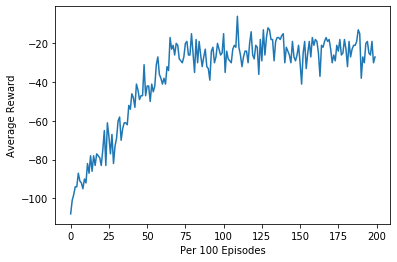

In [8]:
N_MAPS = 100
MAP_SIZE = 10
N_OBSTACLES = int(0.15*(MAP_SIZE*MAP_SIZE))
state_space_size = N_OBSTACLES + 1
maps = []
for i in range (N_MAPS):
    robot_start = [random.randint(0, MAP_SIZE-1), random.randint(0, MAP_SIZE-1)]
    robot_goal  = [random.randint(0, MAP_SIZE-1), random.randint(0, MAP_SIZE-1)]
    
    while (robot_start == robot_goal):
        robot_goal  = [random.randint(0, MAP_SIZE-1), random.randint(0, MAP_SIZE-1)]
        
    ox = [random.randint(0, MAP_SIZE-1) for _ in range(N_OBSTACLES)]
    oy = [random.randint(0, MAP_SIZE-1) for _ in range(N_OBSTACLES)]
    
    env = gym.make('dqn-v0')
    env.init(robot_start[0], robot_start[1], robot_goal[0], robot_goal[1], MAP_SIZE, ox, oy)
    env.seed(0)
    maps.append(env)
    
agent = Agent(state_size=state_space_size, action_size=9, seed=0, qnet_type='simple')
scores_graph, _  = dqn(n_episodes=20000, max_t=50, eps_start=1.0, eps_end=0.01, eps_decay=0.9995, agent=agent, envs=maps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_graph)), scores_graph)
plt.ylabel('Average Reward')
plt.xlabel('Per 100 Episodes')
plt.show()

Based on these results, it seems that after about 7500 episodes, the model reached a sort of steady-state of failure. The positive information to take away from this trial is that the Agent got much better at avoiding the obstacles that it saw and knew to avoid them. However, the negative is that the policy did not really ever have enough chances to find the goal on a 10x10 given our timestep limit of 50 actions, and therefore did not get the reinforcment reward for finding the goal. It instead just moved around for 50 timesteps avoiding obstacles.

Next, we will try a smaller map with slightly less obstacle coverage, and allow 1000 actions before cutting off the episode. We will use an epsilon decay of 0.999995 to encourage a lot of exploration.

Episode 100	Average Score: -81.00
Episode 200	Average Score: -78.00
Episode 300	Average Score: -75.00
Episode 400	Average Score: -80.00
Episode 500	Average Score: -82.00
Episode 600	Average Score: -87.00
Episode 700	Average Score: -80.00
Episode 800	Average Score: -86.00
Episode 900	Average Score: -68.00
Episode 1000	Average Score: -74.00
Episode 1100	Average Score: -72.00
Episode 1200	Average Score: -83.00
Episode 1300	Average Score: -83.00
Episode 1400	Average Score: -73.00
Episode 1500	Average Score: -74.00
Episode 1600	Average Score: -71.00
Episode 1700	Average Score: -73.00
Episode 1800	Average Score: -71.00
Episode 1900	Average Score: -61.00
Episode 2000	Average Score: -72.00
Episode 2100	Average Score: -77.00
Episode 2200	Average Score: -70.00
Episode 2300	Average Score: -75.00
Episode 2400	Average Score: -83.00
Episode 2500	Average Score: -86.00
Episode 2600	Average Score: -84.00
Episode 2700	Average Score: -80.00
Episode 2800	Average Score: -82.00
Episode 2900	Average Score: -

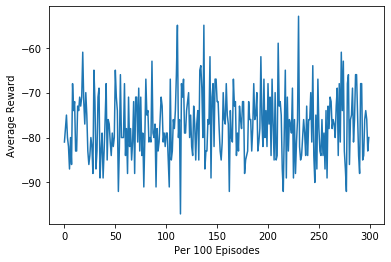

In [11]:
N_MAPS = 100
MAP_SIZE = 8
N_OBSTACLES = int(0.10*(MAP_SIZE*MAP_SIZE))
state_space_size = N_OBSTACLES + 1
maps = []
for i in range (N_MAPS):
    robot_start = [random.randint(0, MAP_SIZE-1), random.randint(0, MAP_SIZE-1)]
    robot_goal  = [random.randint(0, MAP_SIZE-1), random.randint(0, MAP_SIZE-1)]
    
    while (robot_start == robot_goal):
        robot_goal  = [random.randint(0, MAP_SIZE-1), random.randint(0, MAP_SIZE-1)]
        
    ox = [random.randint(0, MAP_SIZE-1) for _ in range(N_OBSTACLES)]
    oy = [random.randint(0, MAP_SIZE-1) for _ in range(N_OBSTACLES)]
    
    env = gym.make('dqn-v0')
    env.init(robot_start[0], robot_start[1], robot_goal[0], robot_goal[1], MAP_SIZE, ox, oy)
    env.seed(0)
    maps.append(env)
    
agent = Agent(state_size=state_space_size, action_size=9, seed=0, qnet_type='simple')
scores_graph, _  = dqn(n_episodes=30000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999995, agent=agent, envs=maps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_graph)), scores_graph)
plt.ylabel('Average Reward')
plt.xlabel('Per 100 Episodes')
plt.show()

We see that the model is not learning very well, so we take this chance to improve our simple neural network model, SimpleQNetwork. The new network, DeepQNetwork, that takes the state of the map as an input and predicts the action space as a result now looks like this:

- LayerNorm(state_size)
- LSTM(state_size, 64)

- LayerNorm(64)
- Linear(64, 128)

- Dropout(0.05)

- LayerNorm(128)
- Linear(128, 128)

- Dropout(0.1)

- LayerNorm(128)
- Linear(128, 32)

- LayerNorm(32)
- LSTM(32, action_size)

The layer normalization is to help the training speed increase and to hopefully help with some suspected vanishing gradients hurting the learning process. Layer normalization, normalizes the input to a layer over the feature dimension, which can help to reduce the effect of covariate shift and make the network more robust to changes in the input distribution. The LSTM layers (long short-term memory) are recurrent layers. LSTM (Long Short-Term Memory) networks can be useful for Deep Q-Learning in certain cases, such as when the agent needs to consider a long history of observations to make decisions. The agent considers several frames of the game to understand the current state. In such a case, an LSTM network can be useful as it can capture the temporal dependencies between the observations and allow the agent to make more informed decisions. The fully connected linear layers all have a ReLU activation function afterward.

We will now also pretrain the model on empty maps, so that it can learn that it should be aiming to go straight to the goal in a straight line. We will then further train that model (in a new agent that is initialized with that biased model) on maps with obstacles to investigate whether it continues to attempt to go straight to the goal, and whether it can learn the random obstacles along the way.

Episode 100	Average Score: -24.15
Episode 200	Average Score: -49.48
Episode 300	Average Score: -38.87
Episode 400	Average Score: -23.80
Episode 500	Average Score: -3.892
Episode 600	Average Score: -20.13
Episode 700	Average Score: -5.353
Episode 800	Average Score: -29.51
Episode 900	Average Score: -18.82
Episode 1000	Average Score: 2.306
Episode 1100	Average Score: -14.27
Episode 1200	Average Score: 26.497
Episode 1300	Average Score: 9.807
Episode 1400	Average Score: -34.52
Episode 1500	Average Score: -4.162
Episode 1600	Average Score: -15.69
Episode 1700	Average Score: -49.14
Episode 1800	Average Score: -21.53
Episode 1900	Average Score: -12.20
Episode 2000	Average Score: -4.161
Episode 2100	Average Score: -25.18
Episode 2200	Average Score: -68.09
Episode 2300	Average Score: -40.16
Episode 2400	Average Score: -26.99
Episode 2500	Average Score: -27.31
Episode 2600	Average Score: -35.67
Episode 2700	Average Score: -50.55
Episode 2800	Average Score: -25.56
Episode 2900	Average Score: -51

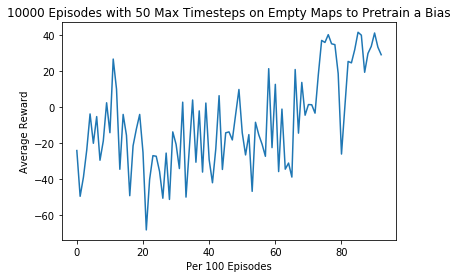

In [4]:
N_MAPS = 20
MAP_SIZE = 10
N_OBSTACLES = int(0.10*(MAP_SIZE*MAP_SIZE))
state_space_size = N_OBSTACLES + 1
maps = []

for i in range (int(N_MAPS)):
    robot_start = [0, 0]
    robot_goal  = [MAP_SIZE-1, MAP_SIZE-1]
        
    ox = [int(0) for _ in range(N_OBSTACLES)]
    oy = [int(MAP_SIZE-1) for _ in range(N_OBSTACLES)]
    
    env = gym.make('dqn-v0')
    env.init(robot_start[0], robot_start[1], robot_goal[0], robot_goal[1], MAP_SIZE, ox, oy)
    env.seed(0)
    maps.append(env)
    
agent = Agent(state_size=state_space_size, action_size=9, seed=0, qnet_type='deep')
scores_graph, pretrained_agent = dqn(n_episodes=10000, max_t=50, eps_start=1.0, eps_end=0.01, eps_decay=0.99995, agent=agent, envs=maps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_graph)), scores_graph)
plt.title('10000 Episodes with 50 Max Timesteps on Empty Maps to Pretrain a Bias')
plt.ylabel('Average Reward')
plt.xlabel('Per 100 Episodes')
plt.show()


In [15]:
torch.save({
            'model_state_dict': pretrained_agent.qnetwork_local.state_dict(),
            'optimizer_state_dict': pretrained_agent.optimizer.state_dict(),
            }, "pretrained_agent.pt")

In [5]:
N_MAPS = 20
MAP_SIZE = 10
N_OBSTACLES = int(0.10*(MAP_SIZE*MAP_SIZE))
state_space_size = N_OBSTACLES + 1
maps = []
for i in range (int(N_MAPS)):
    robot_start = [0, 0]
    robot_goal  = [MAP_SIZE-1, MAP_SIZE-1]
        
    ox = [random.randint(1, MAP_SIZE-2) for _ in range(N_OBSTACLES)]
    oy = [random.randint(1, MAP_SIZE-2) for _ in range(N_OBSTACLES)]
    
    env = gym.make('dqn-v0')
    env.init(robot_start[0], robot_start[1], robot_goal[0], robot_goal[1], MAP_SIZE, ox, oy)
    env.seed(0)
    maps.append(env)
    
checkpoint = torch.load("pretrained_agent.pt")
pretrained_agent = Agent(state_size=state_space_size, action_size=9, seed=0, qnet_type='deep', checkpoint=checkpoint)
scores_graph, qmodel = dqn(n_episodes=9000, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.9995, agent=pretrained_agent, envs=maps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_graph)), scores_graph)
plt.title('9000 Episodes with 100 Max Timesteps, Half Maps Empty')
plt.ylabel('Average Reward')
plt.xlabel('Per 100 Episodes')
plt.show()

Episode 100	Average Score: -101.47
Episode 200	Average Score: -98.597
Episode 300	Average Score: -94.723
Episode 400	Average Score: -98.109
Episode 500	Average Score: -90.04
Episode 600	Average Score: -91.46
Episode 700	Average Score: -90.83
Episode 800	Average Score: -89.19
Episode 900	Average Score: -90.09
Episode 1000	Average Score: -86.25
Episode 1100	Average Score: -86.12
Episode 1200	Average Score: -82.46
Episode 1300	Average Score: -88.48
Episode 1400	Average Score: -84.05
Episode 1500	Average Score: -78.91
Episode 1600	Average Score: -76.08
Episode 1700	Average Score: -73.36
Episode 1800	Average Score: -72.31
Episode 1900	Average Score: -66.80
Episode 2000	Average Score: -71.23
Episode 2100	Average Score: -74.64
Episode 2200	Average Score: -57.49
Episode 2300	Average Score: -60.10
Episode 2400	Average Score: -52.19
Episode 2500	Average Score: -50.13
Episode 2600	Average Score: -52.28
Episode 2700	Average Score: -66.42
Episode 2800	Average Score: -54.03
Episode 2900	Average Scor

KeyboardInterrupt: 

Based on many trials adjusting factors like the discount factor, exploration constant, learning rate, and other hyperparameters, it seems that our model will be very limited in its ability to generalize. In fact, the previous trial was cut off at around 8700, as the model had simply learned that it was best to stay in one place for the entire episode because it saw different obstacles each time, which confused the policy.

Deep Q-Learning (DQL) can sometimes struggle with generalization because it learns to memorize the state-action pairs and the associated rewards for each specific state, rather than learning a more abstract representation of the environment. This can lead to the agent overfitting to the training data and performing poorly on unseen environments.

One reason why DQL may not generalize well is due to the high dimensionality of the state space. Since DQL requires a large amount of training data to learn an accurate Q-function, this can become computationally expensive or even infeasible for high-dimensional state spaces.

Another reason is that DQL relies on the assumption that the environment is stationary and that the agent's actions do not significantly affect the environment. In practice, many real-world environments are non-stationary, and an agent's actions can have a significant impact on the environment, making it difficult to learn an accurate Q-function.

Instead of trying to force this system to learn something that it is not inclined to be good at, let us instead push the limits of what it is already good at: learning one map and optimizing it's path. This still has many applications in the real world, such as navigation through a known environment that humans are not certain about the most optimal path toward. To go back to our analogy from the beginning, we cannot train our agent on all Mario worlds at once and expect it to do them all well. Instead, this type of learning is best suited to mastering one level at a time. We could then string all the models together and play the most optimal game ever played! But instead of our first, easy map (World 1-1) let's give it something difficult (Bowser's Castle).

We have constructed a maze with three key characteristics to test different aspects of the Agent.
- 1) The maze has a dead end path, which will help us see whether or not the model gets stuck in it.
- 2) The maze has multiple correct paths, one being much longer than the other, to test if the agent learns the **shortest** path.
- 3) The maze only has a path that is as wide as the Agent itself, so that we can see whether or not the agent can learn a very precise pathway.

In [ ]:
env = gym.make('dqn-v0')
MAP_SIZE = 10
robot_start = [0, 0]
robot_goal = [9, 9]

maze = [[0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]

# Find the position of the wall in the maze
wall_position = []
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 1:
            wall_position.append((i, j))

# Create x and y vectors
OBSTACLE_X = [pos[0] for pos in wall_position]
OBSTACLE_Y = [pos[1] for pos in wall_position]

N_OBSTACLES = len(OBSTACLE_X)
state_space_size = N_OBSTACLES + 1 # the goal adds one state

env.init(robot_start[0], robot_start[1], robot_goal[0], robot_goal[1], MAP_SIZE, OBSTACLE_X, OBSTACLE_Y)
env.seed(0)
agent = Agent(state_size=state_space_size, action_size=9, seed=0, qnet_type='deep')
maps=[env]
scores_graph, complex_maze_model = dqn(n_episodes=20000, max_t=200, eps_start=1.0, eps_end=0.01, eps_decay=0.99995, agent=agent, envs=maps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_graph)), scores_graph)
plt.title('Complex Model Trained on a Difficult Maze (Single Map)')
plt.ylabel('Average Reward')
plt.xlabel('Per 100 Episodes')
plt.show()